In [1]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5113574.datarmor0/parcels-502090/libparcels_random_0a9167ca-4c5f-41de-93c6-6db77814c839.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=4)
#
client = Client(cluster)

In [3]:
client

<Client: 'tcp://10.148.0.192:34456' processes=0 threads=0, memory=0 B>

In [4]:
# Lagrangian data
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']
df = pa.degs2ms(df) #Convert in m/s 


In [5]:
df_sub = df.drop(columns=['sea_level','temperature','salinity','Eta_interp','SSS_interp','SST_interp'])
df_sub = df_sub.rename(columns={'SSU_interp':'mean_zonal_velocity','SSV_interp':'mean_meridional_velocity'})
df_sub = df_sub.persist()
#df_sub = df_sub.get_partition(0).persist()
df_sub

Dask DataFrame Structure:
                trajectory      lat      lon        z zonal_velocity meridional_velocity mean_zonal_velocity mean_meridional_velocity
npartitions=749                                                                                                                      
                     int32  float64  float64  float64        float64             float32             float64                  float64
                       ...      ...      ...      ...            ...                 ...                 ...                      ...
...                    ...      ...      ...      ...            ...                 ...                 ...                      ...
                       ...      ...      ...      ...            ...                 ...                 ...                      ...
                       ...      ...      ...      ...            ...                 ...                 ...                      ...
Dask Name: rename, 749 tasks

In [6]:
lonmin,latmin,lonmax,latmax = [16,-40,19,-37]

In [7]:
df_bis = df_sub[df_sub.lon<lonmax].persist()
df_bis = df_bis[df_bis.lon>lonmin].persist()
df_bis = df_bis[df_bis.lat<latmax].persist()
df_bis = df_bis[df_bis.lat>latmin].persist()

In [8]:
# Binning the Eulerian mean field (to compare with Lagrangian binned statisitcs)

dl = 1.
lon = np.arange(lonmin,lonmax, dl)
lat = np.arange(latmin, latmax, dl)

df_bis['lon'] = (df_bis['lon']+180)%360 - 180
df_bis['lon_cut'] = df_bis['lon'].map_partitions(pd.cut, lon)
df_bis['lat_cut'] = df_bis['lat'].map_partitions(pd.cut, lat)

In [9]:
# Dates of start and end of simulation
t_start = df_bis.index.min().compute()
t_end = df_bis.index.max().compute()
delta_t = (t_end - t_start)/pd.Timedelta('1D') # in days

print(t_start, t_end, delta_t)

2011-11-15 00:00:00 2012-11-09 01:00:00 360.0416666666667


In [10]:
# temporal bins
#t_bins = pd.date_range(t_start, t_end, freq='1M')
t_bins = pd.date_range(t_start, t_end, freq='1MS') # starts at the beginning of each month
cut = lambda df, bins: pd.cut(df.index.to_series(), bins=bins)

In [11]:
df_bis['time_cut'] = df_bis.map_partitions(cut, t_bins)

In [12]:
df_1dl = df_bis.compute()
#df_01dl = df_bis.compute()

In [14]:
group=['lon_cut','lat_cut']
df_bmean = df_1dl.groupby(group).mean()
#df_bmean_01 = df_01dl.groupby(group).mean()
for V in ['zonal_velocity','meridional_velocity','mean_zonal_velocity','mean_meridional_velocity']:
    #df_01dl[V+'_transform'] = df_01dl.groupby(group)[V].transform('mean')
    df_1dl[V+'_transform'] = df_1dl.groupby(group)[V].transform('mean')



In [16]:
df_bmean = pa.add_geodata(df_bmean)
ds_bmean = (df_bmean
           .drop(columns=['Coordinates'])
           .set_index(['lon', 'lat'])
           .to_xarray()
           )

In [21]:
df_count = df_1dl.groupby(group).count()
df_count = pa.add_geodata(df_count)



df_count = df_count.drop(columns=['Coordinates']).set_index(['lon', 'lat']).to_xarray()

In [23]:
ds_bmean['count_flts'] = df_count.trajectory

# Eulerian data

In [17]:
def read_Ediag(V,diags):
    ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in diags])

    grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
    ds = xr.merge([ds,grid])
    #ds = ds#.isel(i = slice(0,None,4), j = slice(0,None,4), i_g = slice(0,None,4), j_g = slice(0,None,4))
    ds['lon'] = 0*ds.face+ds.XC
    ds['lat'] = 0*ds.face+ds.YC
    ds = ds.compute()
    # Rotation velocity field
    for diag in diags:
        ds['zonal_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.CS - ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.SN
        ds['meridional_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.SN + ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.CS

        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
 #   ds = llcreader.faces_dataset_to_latlon(ds)
    return ds

In [18]:
# Eulerian data
V = ["SSU","SSV"]#["SSU", "SSV"]
D = ["mean"]#, "prime_mean","prime_mean_sq"]
ds = read_Ediag(V,D)

In [24]:
ds = ds.isel(face=1)


In [25]:
ds = ds.drop(['i_g','j_g'])

In [26]:
ds_Emean = xr.Dataset({'zonal_velocity_mean':(['lat','lon'],ds.zonal_velocity_mean.values),
                       'meridional_velocity_mean':(['lat','lon'],ds.meridional_velocity_mean.values)},
                      coords={'lon':ds.lon.values[0,:],'lat':ds.lat.values[:,0]})

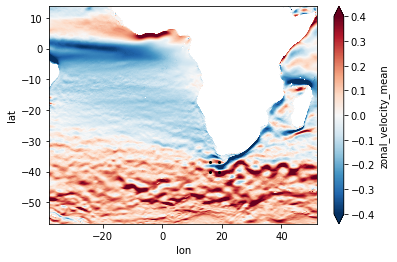

In [25]:
vmax=0.4
ds_Emean.zonal_velocity_mean.plot(vmax=vmax)
plt.scatter([lonmin,lonmax,lonmin,lonmax],[latmax,latmin,latmin,latmax],s=4,c='k')

In [27]:
ds_Emean = ds_Emean.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
ds_Emean.load()

<xarray.Dataset>
Dimensions:                   (lat: 199, lon: 144)
Coordinates:
  * lon                       (lon) float64 16.01 16.03 16.05 ... 18.97 18.99
  * lat                       (lat) float64 -39.99 -39.97 ... -37.02 -37.0
Data variables:
    zonal_velocity_mean       (lat, lon) float32 0.3534 0.3546 ... 0.2804 0.2801
    meridional_velocity_mean  (lat, lon) float32 0.02299 0.02301 ... 0.1162

### Visualization

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


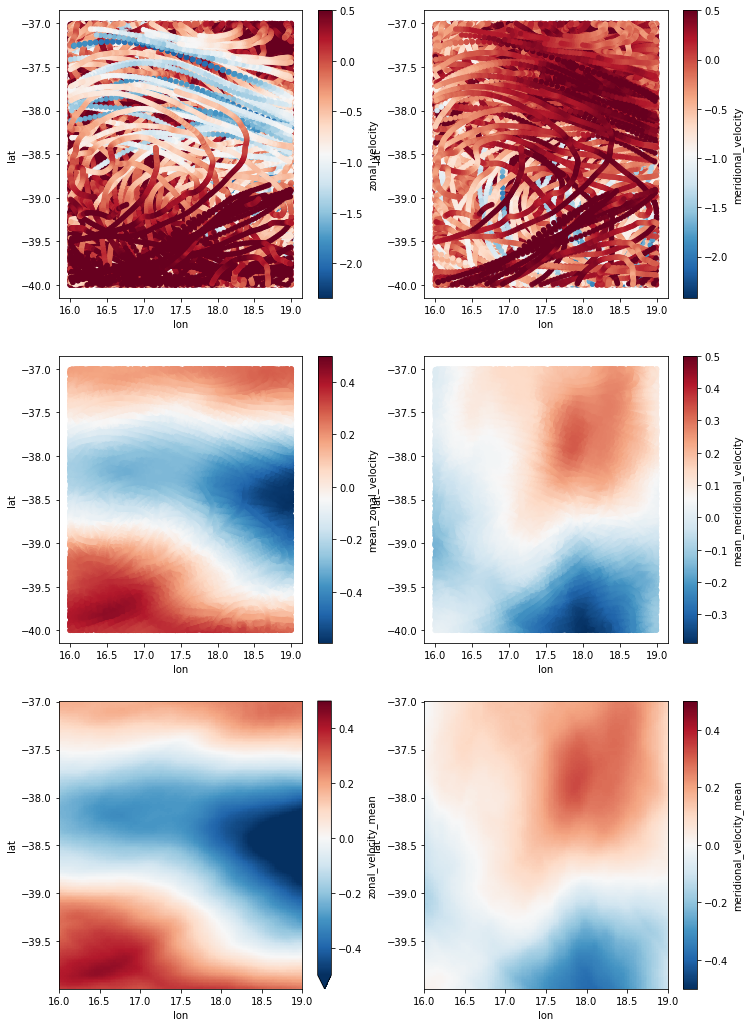

In [27]:
vmax=0.5
fig,ax = plt.subplots(3,2,figsize=(12,18))
df_1dl.plot.scatter(y='lat',x='lon',c='zonal_velocity',ax=ax[0,0],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='mean_zonal_velocity',ax=ax[1,0],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='meridional_velocity',ax=ax[0,1],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='mean_meridional_velocity',ax=ax[1,1],cmap='RdBu_r',vmax=vmax)
ds_Emean.zonal_velocity_mean.plot(y='lat',x='lon',ax=ax[2,0],cmap='RdBu_r',vmax=vmax)
ds_Emean.meridional_velocity_mean.plot(y='lat',x='lon',ax=ax[2,1],cmap='RdBu_r',vmax=vmax)

#### Binned mean

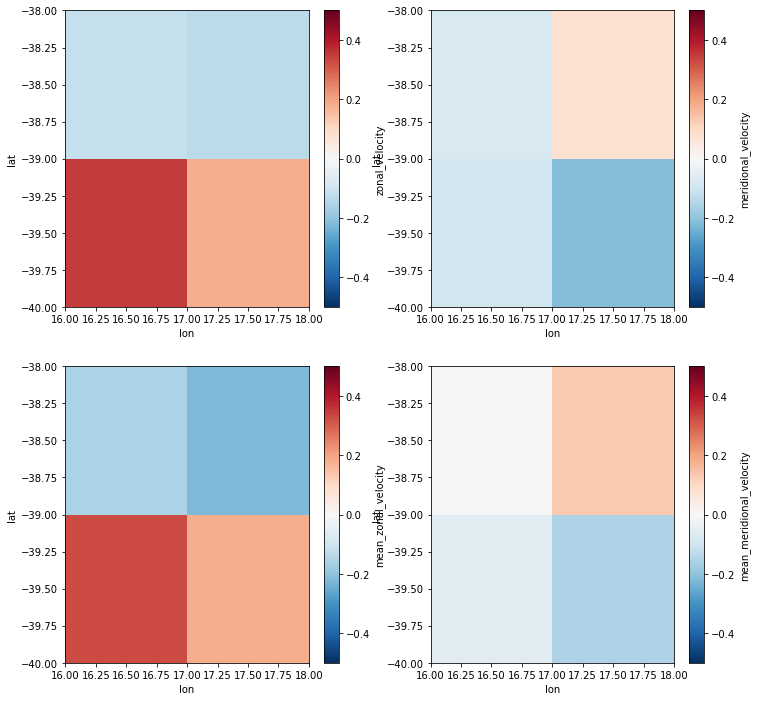

In [28]:
fig,ax = plt.subplots(2,2,figsize=(12,12))
ds_bmean.zonal_velocity.plot(y='lat',ax=ax[0,0],vmax=vmax)
ds_bmean.meridional_velocity.plot(y='lat',ax=ax[0,1],vmax=vmax)
ds_bmean.mean_zonal_velocity.plot(y='lat',ax=ax[1,0],vmax=vmax)
ds_bmean.mean_meridional_velocity.plot(y='lat',ax=ax[1,1],vmax=vmax)

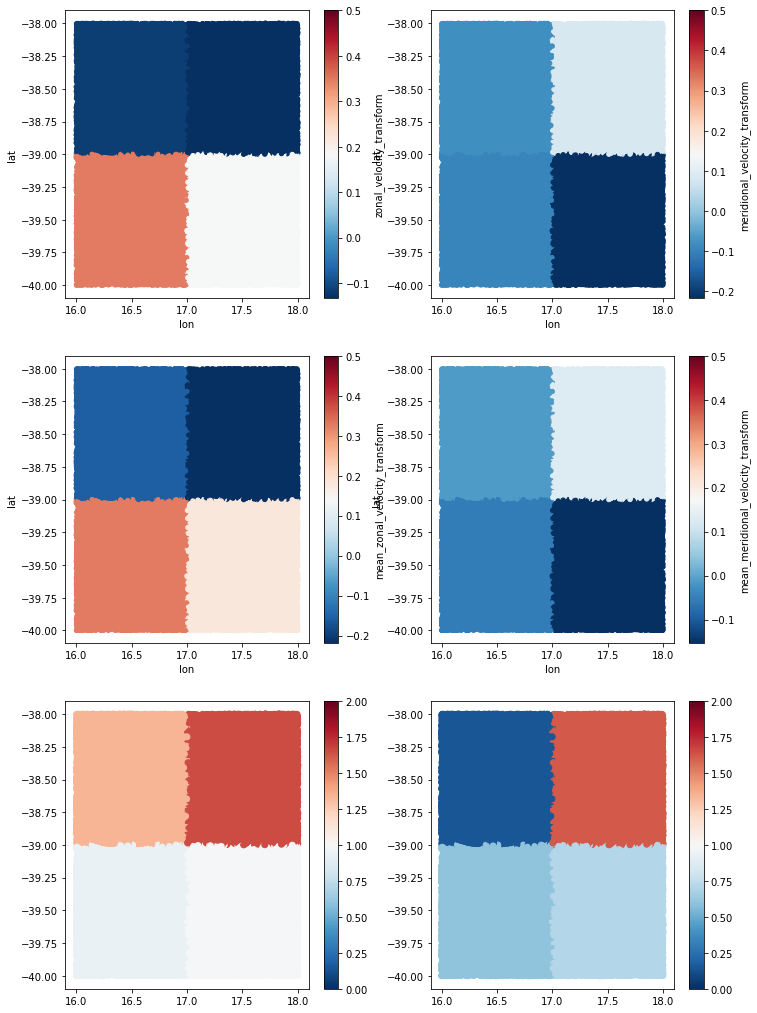

In [71]:
vmax=0.5
fig,ax = plt.subplots(3,2,figsize=(12,18))
df_1dl.plot.scatter(y='lat',x='lon',c='zonal_velocity_transform',ax=ax[0,0],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='mean_zonal_velocity_transform',ax=ax[1,0],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='meridional_velocity_transform',ax=ax[0,1],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='mean_meridional_velocity_transform',ax=ax[1,1],cmap='RdBu_r',vmax=vmax)
cs = ax[2,0].scatter(df_1dl.lon,df_1dl.lat,
                     c=np.abs(df_1dl.mean_zonal_velocity_transform/df_1dl.zonal_velocity_transform)
                     ,cmap='RdBu_r',vmax=2,vmin=0)
plt.colorbar(cs,ax=ax[2,0])
cs = ax[2,1].scatter(df_1dl.lon,df_1dl.lat,
                c=np.abs(df_1dl.mean_meridional_velocity_transform/df_1dl.meridional_velocity_transform)
                     ,cmap='RdBu_r',vmax=2,vmin=0)
plt.colorbar(cs,ax=ax[2,1])

In [30]:
for V in ['zonal_velocity','meridional_velocity','mean_zonal_velocity','mean_meridional_velocity']:
    df_1dl[V+'_transform_square'] = df_1dl[V+'_transform']**2

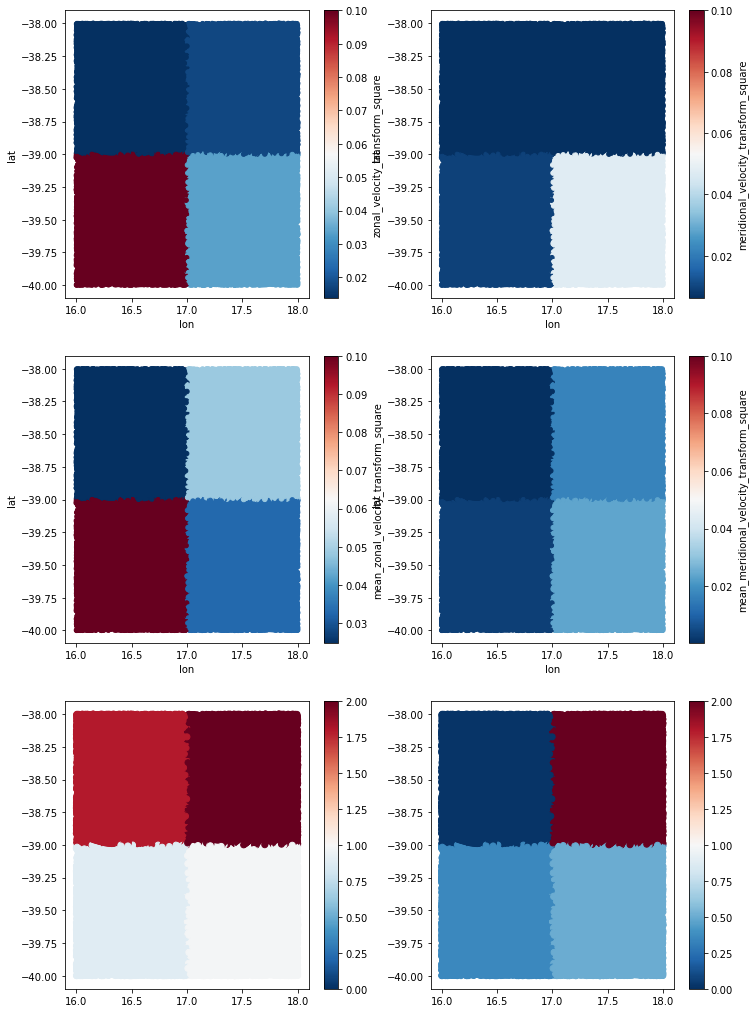

In [72]:
vmax=0.1
fig,ax = plt.subplots(3,2,figsize=(12,18))
df_1dl.plot.scatter(y='lat',x='lon',c='zonal_velocity_transform_square',ax=ax[0,0],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='mean_zonal_velocity_transform_square',ax=ax[1,0],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='meridional_velocity_transform_square',ax=ax[0,1],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='mean_meridional_velocity_transform_square',ax=ax[1,1],cmap='RdBu_r',vmax=vmax)
cs = ax[2,0].scatter(df_1dl.lon,df_1dl.lat,
                     c=df_1dl.mean_zonal_velocity_transform_square/df_1dl.zonal_velocity_transform_square
                     ,cmap='RdBu_r',vmax=2,vmin=0)
plt.colorbar(cs,ax=ax[2,0])
cs = ax[2,1].scatter(df_1dl.lon,df_1dl.lat,
                c=df_1dl.mean_meridional_velocity_transform_square/df_1dl.meridional_velocity_transform_square,
                     cmap='RdBu_r',vmax=2,vmin=0)
plt.colorbar(cs,ax=ax[2,1])

#### Repartition number of floats

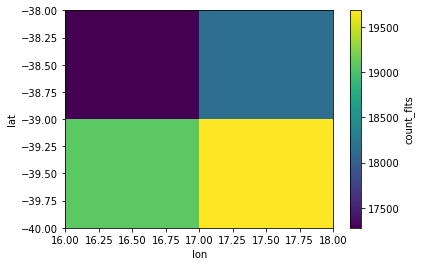

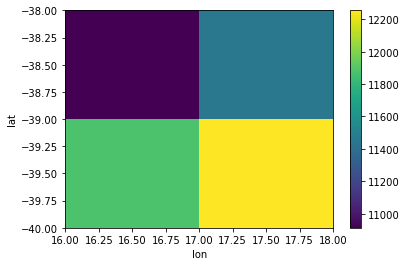

In [34]:
ds_bmean.count_flts.plot(y='lat')
plt.figure()
(ds_bmean.count_flts/ds_bmean.area).plot(y='lat')

In [35]:
group=['lon_cut','lat_cut','time_cut']
df_mean = df_1dl.groupby(group).mean()

In [82]:
df_mean = pa.add_geodata(df_mean)


df_mean['time'] = df_mean.index.to_frame().time_cut.apply(lambda d: d.left)
df_mean = df_mean.set_index(['lon','lat','time'])

In [84]:
ds_mean = (df_mean
           .drop(columns=['Coordinates'])
           .to_xarray()
           )

In [72]:
count = (df_1dl
         .groupby(group)
         .count()['z']
         .rename('count')
         .to_frame()
        )
count = pa.add_geodata(count)


count['time'] = count.index.to_frame().time_cut.apply(lambda d: d.left)
count = count.set_index(['lon','lat','time'])
#count = count/30 # normalize per number of days

In [73]:
count

count  \
lon  lat   time                         
16.5 -39.5 2011-12-01 00:00:00    691   
           2012-01-01 00:00:00   1390   
           2012-02-01 00:00:00   1171   
           2012-03-01 00:00:00   1451   
           2012-04-01 00:00:00   2074   
           2012-05-01 00:00:00   1628   
           2012-06-01 00:00:00   1868   
           2012-07-01 00:00:00   2023   
           2012-08-01 00:00:00   2120   
           2012-09-01 00:00:00   1979   
           2012-10-01 00:00:00   1583   
     -38.5 2011-12-01 00:00:00   1236   
           2012-01-01 00:00:00   1257   
           2012-02-01 00:00:00   1383   
           2012-03-01 00:00:00   1270   
           2012-04-01 00:00:00   1138   
           2012-05-01 00:00:00   2754   
           2012-06-01 00:00:00   1901   
           2012-07-01 00:00:00    630   
           2012-08-01 00:00:00   1060   
           2012-09-01 00:00:00   2094   
           2012-10-01 00:00:00   1627   
17.5 -39.5 2011-12-01 00:00:00   1405   
           2012-01-01 00:00:00   2120   
           2012-02-01 00:00:00    934   
           2012-03-01 00:00:00   1670   
           2012-04-01 00:00:00   1819   
           2012-05-01 00:00:00   1692   
           2012-06-01 00:00:00   1940   
           2012-07-01 00:00:00   1698   
           2012-08-01 00:00:00   1980   
           2012-09-01 00:00:00   2412   
           2012-10-01 00:00:00    814   
     -38.5 2011-12-01 00:00:00   1419   
           2012-01-01 00:00:00   1260   
           2012-02-01 00:00:00   1463   
           2012-03-01 00:00:00   2708   
           2012-04-01 00:00:00   1546   
           2012-05-01 00:00:00   1437   
           2012-06-01 00:00:00   1783   
           2012-07-01 00:00:00   1046   
           2012-08-01 00:00:00    844   
           2012-09-01 00:00:00   2851   
           2012-10-01 00:00:00    955   

                                                                      Coordinates  \
lon  lat   time                                                                     
16.5 -39.5 2011-12-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-01-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-02-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-03-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-04-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-05-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-06-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-07-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-08-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-09-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-10-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
     -38.5 2011-12-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-01-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-02-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-03-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-04-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-05-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-06-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-07-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-08-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-09-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-10-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
17.5 -39.5 2011-12-01 00:00:00  POLYGON ((17.00000 -40.00000, 18.00000 -40.000...   
           2012-01-0

In [74]:
count = count.drop(columns=['Coordinates']).to_xarray()

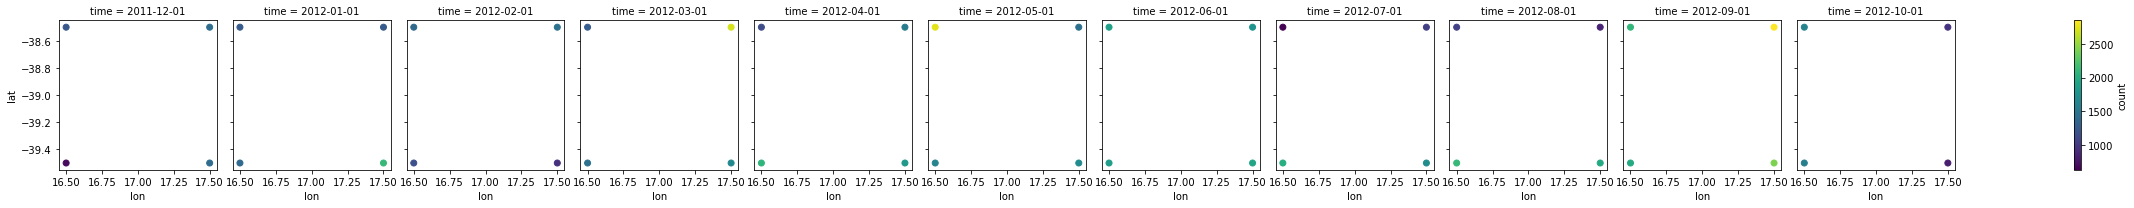

In [80]:
count.plot.scatter(x='lon',y='lat',col='time',hue='count')

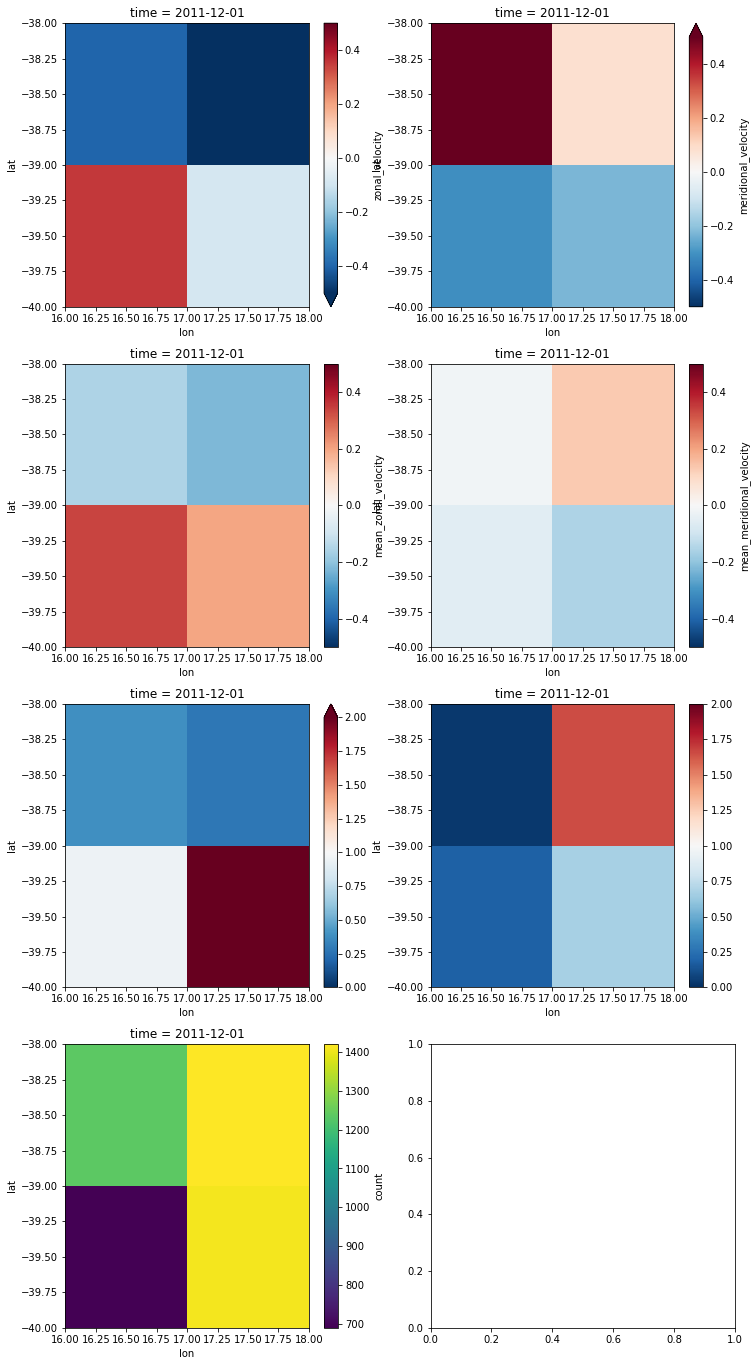

In [94]:
vmax=0.5
fig,ax = plt.subplots(4,2,figsize=(12,24))
ds_mean.zonal_velocity.isel(time=0).plot(y='lat',ax=ax[0,0],vmax=vmax)
ds_mean.meridional_velocity.isel(time=0).plot(y='lat',ax=ax[0,1],vmax=vmax)
ds_mean.mean_zonal_velocity.isel(time=0).plot(y='lat',ax=ax[1,0],vmax=vmax)
ds_mean.mean_meridional_velocity.isel(time=0).plot(y='lat',ax=ax[1,1],vmax=vmax)
np.abs(ds_mean.mean_zonal_velocity/ds_mean.zonal_velocity).isel(time=0).plot(y='lat',ax=ax[2,0],vmax=2,vmin=0,cmap='RdBu_r')
np.abs(ds_mean.mean_meridional_velocity/ds_mean.meridional_velocity).isel(time=0).plot(y='lat',ax=ax[2,1],vmax=2,vmin=0,cmap='RdBu_r')
count.isel(time=0)['count'].plot(y='lat',ax=ax[3,0])

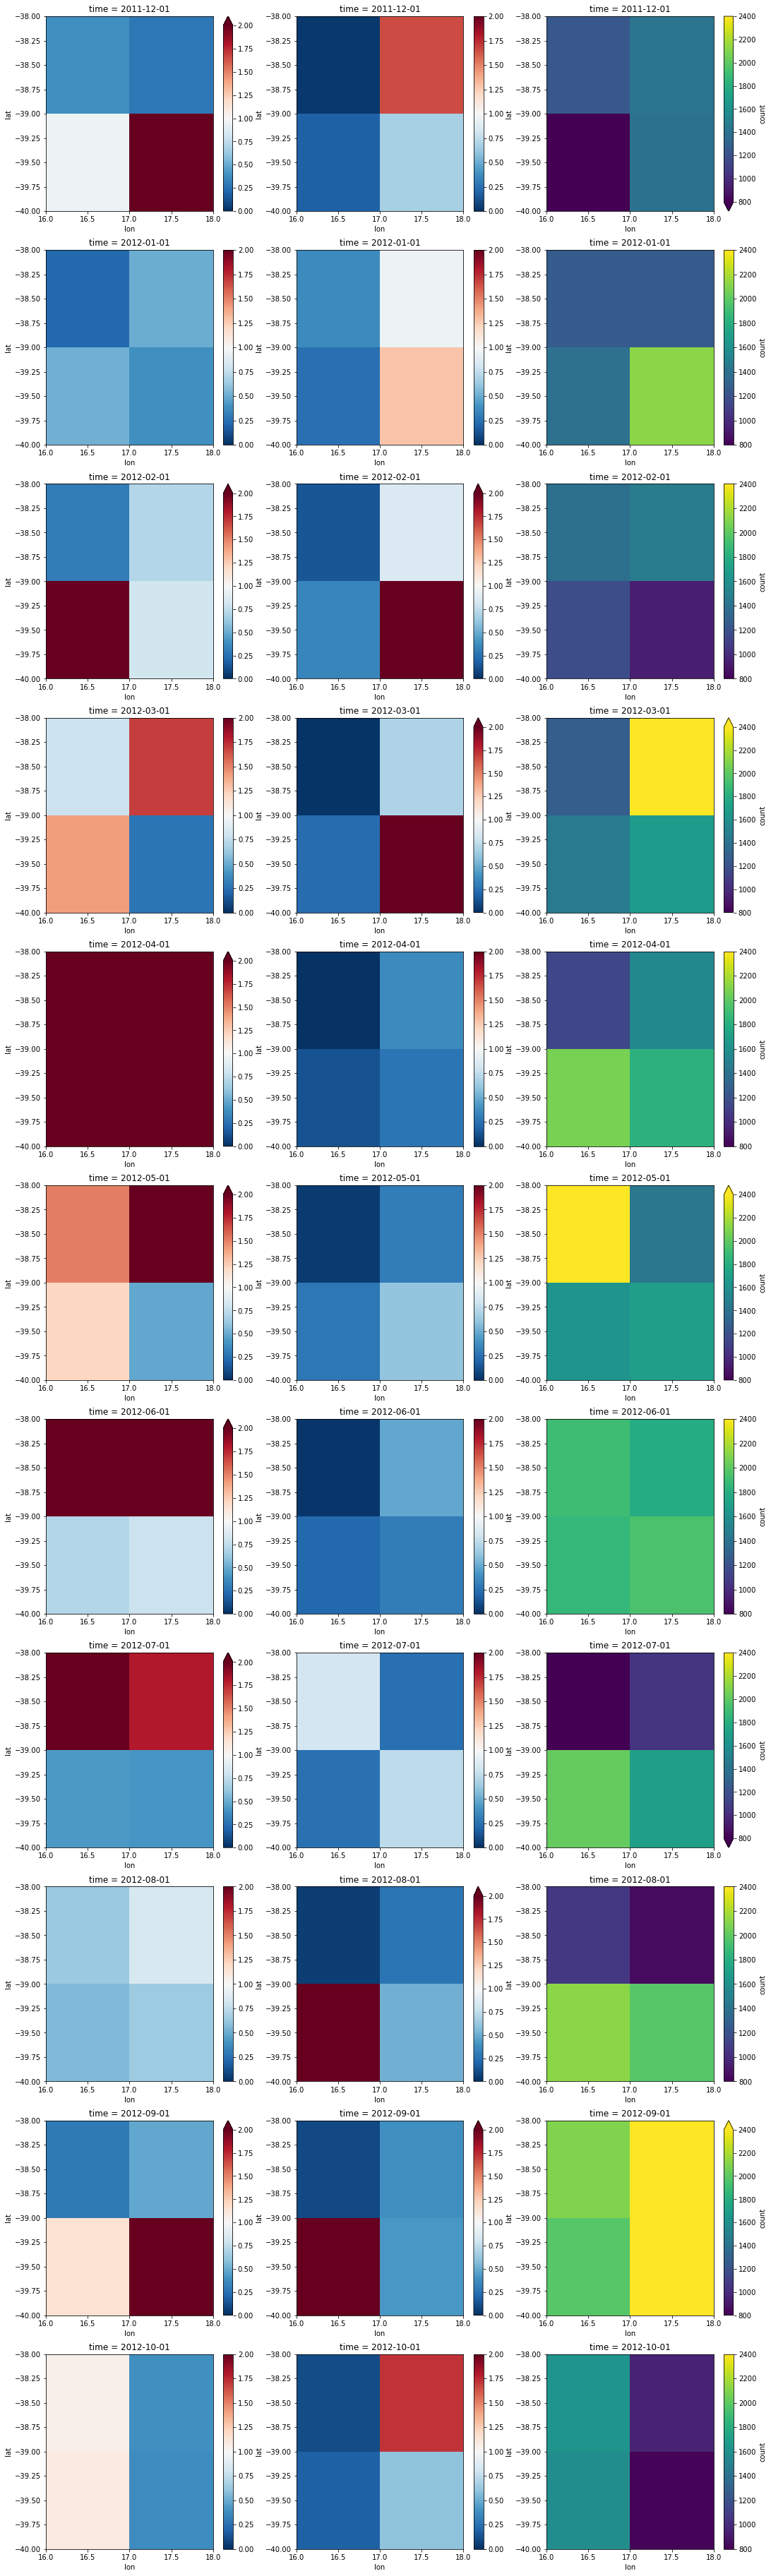

In [98]:
vmax=0.5
fig,ax = plt.subplots(count.time.size,3,figsize=(18,count.time.size*6))
for i in range(count.time.size):
    np.abs(ds_mean.mean_zonal_velocity/ds_mean.zonal_velocity).isel(time=i).plot(y='lat',ax=ax[i,0],vmax=2,vmin=0,cmap='RdBu_r')
    np.abs(ds_mean.mean_meridional_velocity/ds_mean.meridional_velocity).isel(time=i).plot(y='lat',ax=ax[i,1],vmax=2,vmin=0,cmap='RdBu_r')
    count.isel(time=i)['count'].plot(y='lat',ax=ax[i,2],vmax=2400,vmin = 800)

#### Bins of 0.1° width:

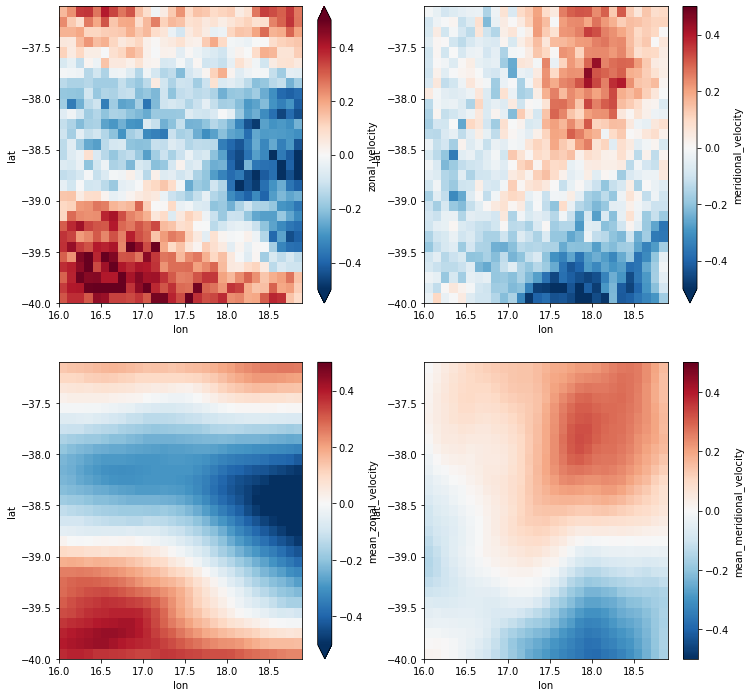

In [49]:
vmax= 0.5

fig,ax = plt.subplots(2,2,figsize=(12,12))
ds_bmean.zonal_velocity.plot(y='lat',ax=ax[0,0],vmax=vmax)
ds_bmean.meridional_velocity.plot(y='lat',ax=ax[0,1],vmax=vmax)
ds_bmean.mean_zonal_velocity.plot(y='lat',ax=ax[1,0],vmax=vmax)
ds_bmean.mean_meridional_velocity.plot(y='lat',ax=ax[1,1],vmax=vmax)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/m

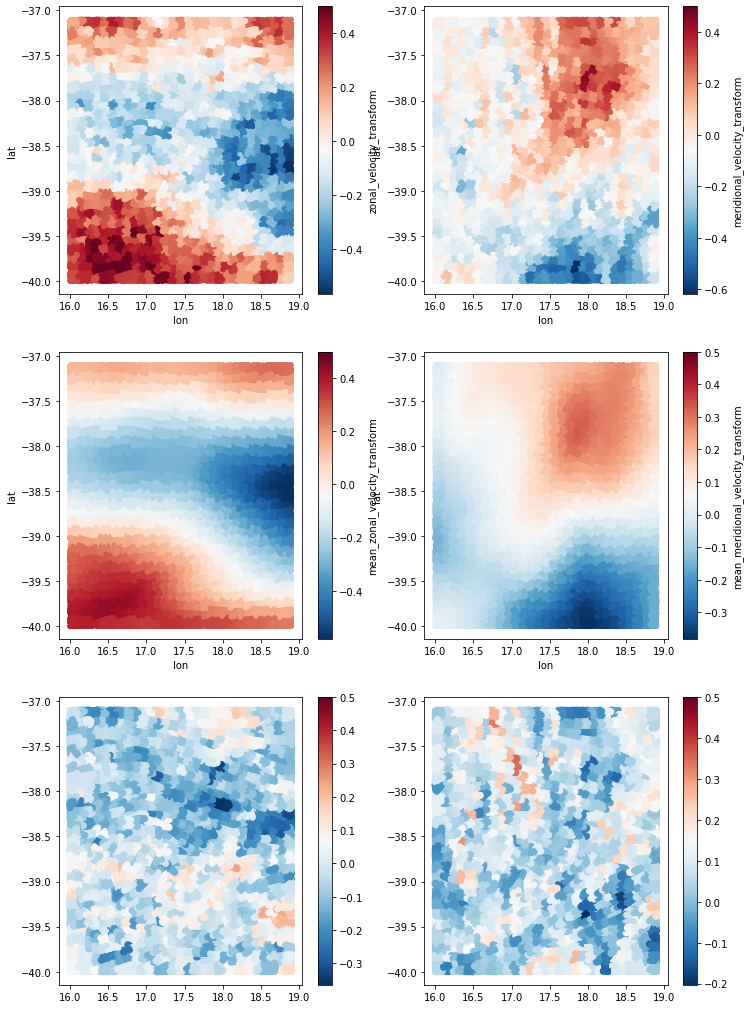

In [63]:
vmax=0.5
fig,ax = plt.subplots(3,2,figsize=(12,18))
df_01dl.plot.scatter(y='lat',x='lon',c='zonal_velocity_transform',ax=ax[0,0],cmap='RdBu_r',vmax=vmax)
df_01dl.plot.scatter(y='lat',x='lon',c='mean_zonal_velocity_transform',ax=ax[1,0],cmap='RdBu_r',vmax=vmax)
df_01dl.plot.scatter(y='lat',x='lon',c='meridional_velocity_transform',ax=ax[0,1],cmap='RdBu_r',vmax=vmax)
df_01dl.plot.scatter(y='lat',x='lon',c='mean_meridional_velocity_transform',ax=ax[1,1],cmap='RdBu_r',vmax=vmax)
cs = ax[2,0].scatter(df_01dl.lon,df_01dl.lat,
                     c=df_01dl.mean_zonal_velocity_transform-df_01dl.zonal_velocity_transform,cmap='RdBu_r',vmax=vmax)
plt.colorbar(cs,ax=ax[2,0])
cs = ax[2,1].scatter(df_01dl.lon,df_01dl.lat,
                c=df_01dl.mean_meridional_velocity_transform-df_01dl.meridional_velocity_transform,cmap='RdBu_r',vmax=vmax)
plt.colorbar(cs,ax=ax[2,1])

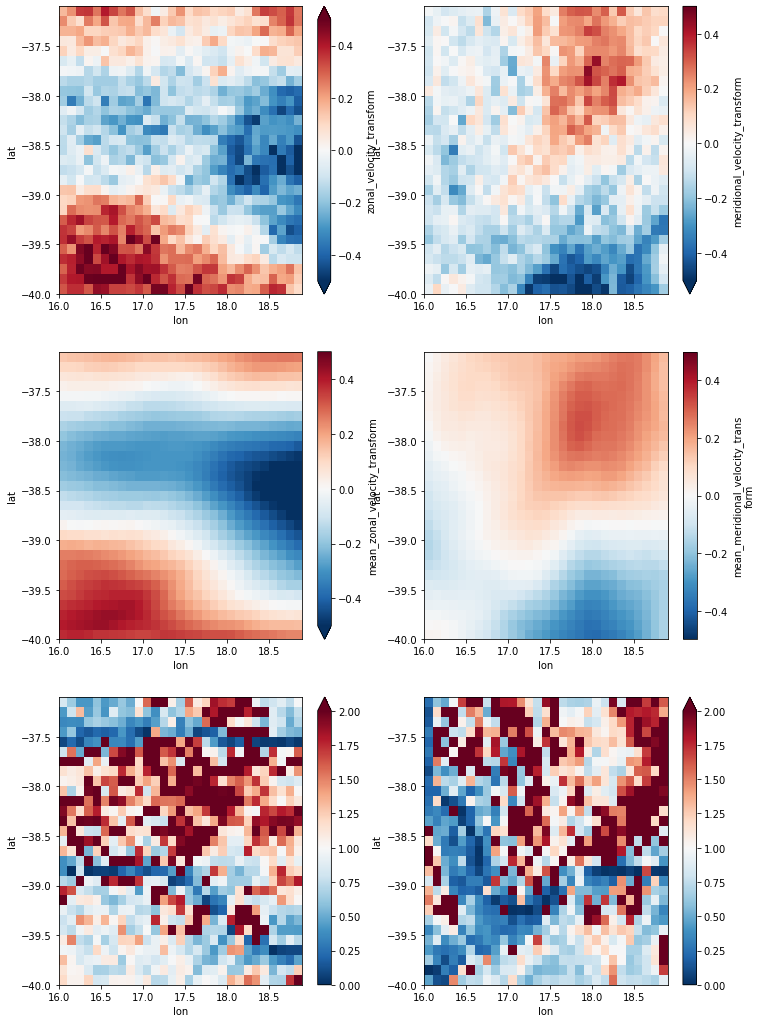

In [70]:
vmax= 0.5

fig,ax = plt.subplots(3,2,figsize=(12,18))
ds_bmean.zonal_velocity_transform.plot(y='lat',ax=ax[0,0],vmax=vmax)
ds_bmean.meridional_velocity_transform.plot(y='lat',ax=ax[0,1],vmax=vmax)

ds_bmean.mean_zonal_velocity_transform.plot(y='lat',ax=ax[1,0],vmax=vmax)
ds_bmean.mean_meridional_velocity_transform.plot(y='lat',ax=ax[1,1],vmax=vmax)

np.abs(ds_bmean.mean_zonal_velocity_transform/ds_bmean.zonal_velocity_transform).plot(y='lat',ax=ax[2,0],
                                                                                      cmap='RdBu_r',vmax=2,vmin=0)
np.abs(ds_bmean.mean_meridional_velocity_transform/ds_bmean.meridional_velocity_transform).plot(y='lat',ax=ax[2,1],
                                                                                          cmap='RdBu_r',vmax=2,vmin=0)

In [73]:
for V in ['zonal_velocity','meridional_velocity','mean_zonal_velocity','mean_meridional_velocity']:
    df_01dl[V+'_transform_square'] = df_01dl[V+'_transform']**2

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/m

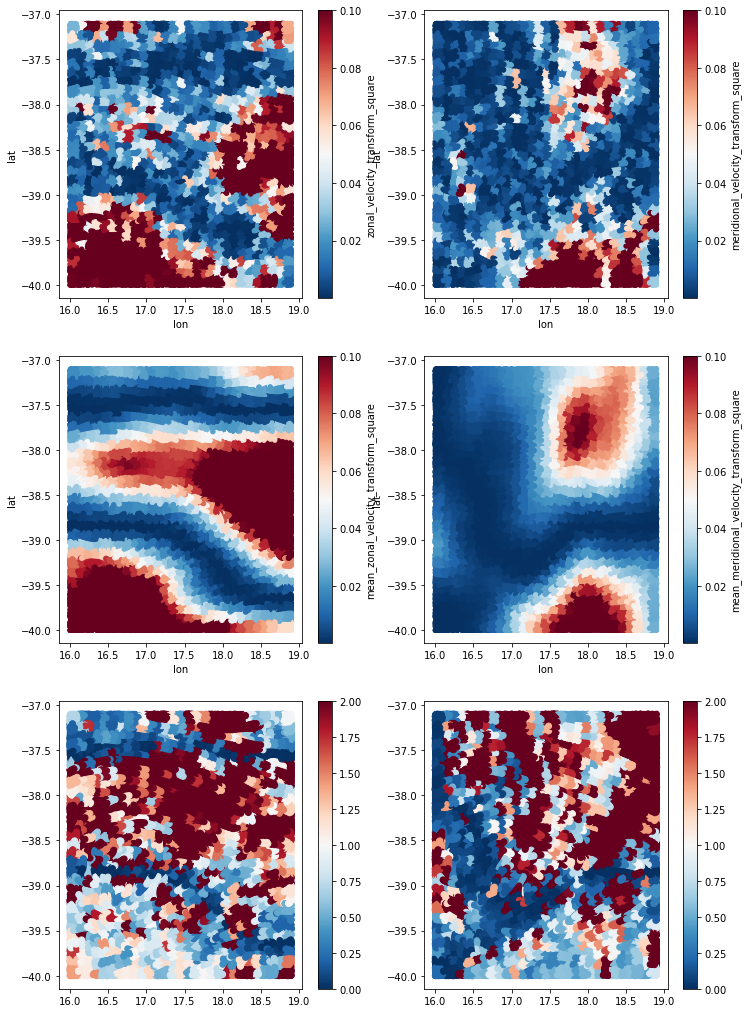

In [74]:
vmax=0.1
fig,ax = plt.subplots(3,2,figsize=(12,18))
df_01dl.plot.scatter(y='lat',x='lon',c='zonal_velocity_transform_square',ax=ax[0,0],cmap='RdBu_r',vmax=vmax)
df_01dl.plot.scatter(y='lat',x='lon',c='mean_zonal_velocity_transform_square',ax=ax[1,0],cmap='RdBu_r',vmax=vmax)
df_01dl.plot.scatter(y='lat',x='lon',c='meridional_velocity_transform_square',ax=ax[0,1],cmap='RdBu_r',vmax=vmax)
df_01dl.plot.scatter(y='lat',x='lon',c='mean_meridional_velocity_transform_square',ax=ax[1,1],cmap='RdBu_r',vmax=vmax)
cs = ax[2,0].scatter(df_01dl.lon,df_01dl.lat,
                     c=df_01dl.mean_zonal_velocity_transform_square/df_01dl.zonal_velocity_transform_square
                     ,cmap='RdBu_r',vmax=2,vmin=0)
plt.colorbar(cs,ax=ax[2,0])
cs = ax[2,1].scatter(df_01dl.lon,df_01dl.lat,
                c=df_01dl.mean_meridional_velocity_transform_square/df_01dl.meridional_velocity_transform_square,
                     cmap='RdBu_r',vmax=2,vmin=0)
plt.colorbar(cs,ax=ax[2,1])

### Test 1 partition

In [11]:
df_sub = df_sub.compute()

In [10]:
df_sub['zonal_velocity_mean_transform'] = df_sub.groupby(['lon_cut','lat_cut']).zonal_velocity.transform('mean')
df_sub['meridional_velocity_mean_transform'] = df_sub.groupby(['lon_cut','lat_cut']).meridional_velocity.transform('mean')

<ipython-input-10-ce0780c20d9c>:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .transform(func)
  After:  .transform(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .transform(func, meta=('x', 'f8'))            for series result
  df_sub['zonal_velocity_mean_transform'] = df_sub.groupby(['lon_cut','lat_cut']).zonal_velocity.transform('mean')
<ipython-input-10-ce0780c20d9c>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .transform(func)
  After:  .transform(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .transform(func, meta=('x', 'f8'))            for series result
  df_sub['meridional_velocity_mean_transform'] = df_sub.groupby(['lon_cut','lat_cut']).meridional_velocity.transform('mean')


In [38]:
df_sub['zonal_velocity_mean_transform_sq'] = df_sub['zonal_velocity_mean_transform']**2

In [12]:
df_sub['velocity_amplitude'] = np.sqrt(df_sub['zonal_velocity']**2+df_sub['meridional_velocity']**2)
df_sub['mean_velocity_amplitude'] = np.sqrt(df_sub['mean_zonal_velocity']**2+df_sub['mean_meridional_velocity']**2)
df_sub['velocity_amplitude_mean_transform'] = np.sqrt(df_sub['zonal_velocity_mean_transform']**2+df_sub['meridional_velocity_mean_transform']**2)


In [13]:
group=['lon_cut','lat_cut']
mean_flts = df_sub.groupby(group).mean()

In [14]:
mean_flts = pa.add_geodata(mean_flts)
ds_mean = (mean_flts
           .drop(columns=['Coordinates'])
           .set_index(['lon', 'lat'])
           .to_xarray()
           )

(-180.407, -120.0)

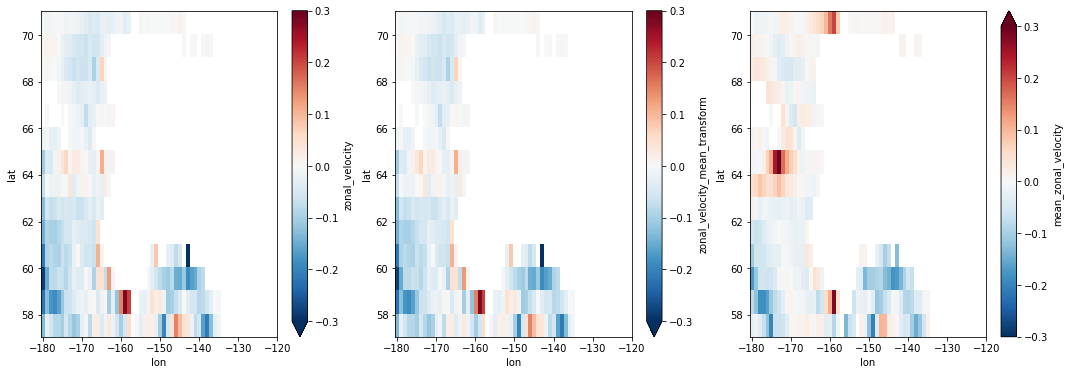

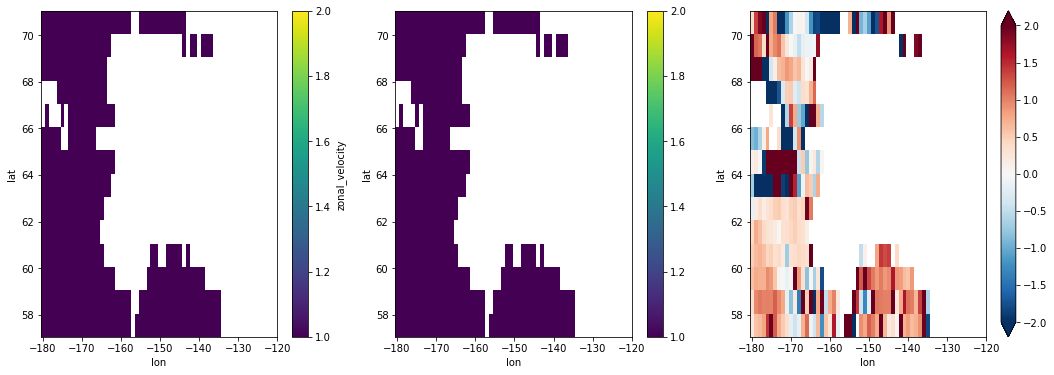

In [20]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
ds_mean.zonal_velocity.plot(y='lat',vmax=0.3,ax=ax[0])
ax[0].set_xlim(None,-120)
ds_mean.zonal_velocity_mean_transform.plot(y='lat',vmax=0.3,ax=ax[1])
ax[1].set_xlim(None,-120)
ds_mean.mean_zonal_velocity.plot(y='lat',vmax=0.3,ax=ax[2])
ax[2].set_xlim(None,-120)
fig,ax = plt.subplots(1,3,figsize=(18,6))
(ds_mean.zonal_velocity/ds_mean.zonal_velocity).plot(y='lat',vmax=2,ax=ax[0])
ax[0].set_xlim(None,-120)
(ds_mean.zonal_velocity_mean_transform/ds_mean.zonal_velocity).plot(y='lat',vmax=2,ax=ax[1])
ax[1].set_xlim(None,-120)
(ds_mean.mean_zonal_velocity/ds_mean.zonal_velocity).plot(y='lat',vmax=2,ax=ax[2])
ax[2].set_xlim(None,-120)

(-180.407, -120.0)

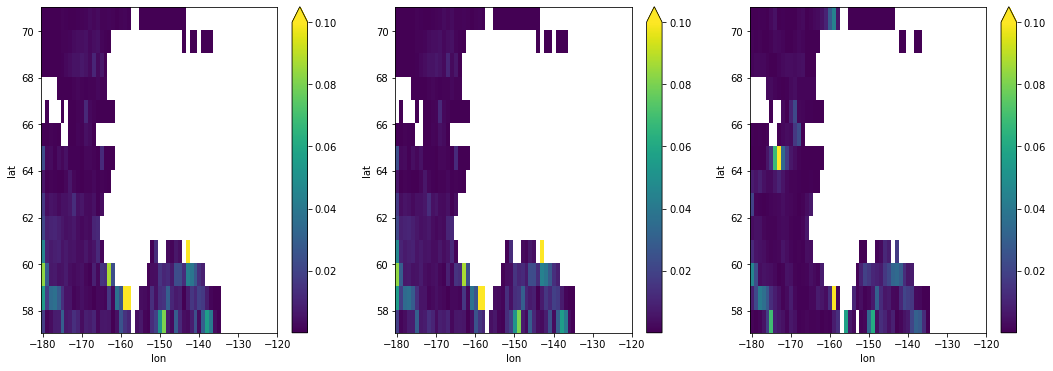

In [22]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
(ds_mean.zonal_velocity**2+ds_mean.meridional_velocity**2).plot(y='lat',vmax=0.1,ax=ax[0])
ax[0].set_xlim(None,-120)
(ds_mean.zonal_velocity_mean_transform**2+ds_mean.meridional_velocity_mean_transform**2).plot(y='lat',vmax=0.1,ax=ax[1])
ax[1].set_xlim(None,-120)
(ds_mean.mean_zonal_velocity**2+ds_mean.mean_meridional_velocity**2).plot(y='lat',vmax=0.1,ax=ax[2])
ax[2].set_xlim(None,-120)

### Spatial tests

In [6]:
df_sub['zonal_velocity_square'] = df_sub['zonal_velocity']**2
df_sub['mean_zonal_velocity_square'] = df_sub['mean_zonal_velocity']**2

In [7]:
df_sub['meridional_velocity_square'] = df_sub['meridional_velocity']**2
df_sub['mean_meridional_velocity_square'] = df_sub['mean_meridional_velocity']**2

In [8]:
df_sub['MKE'] = df_sub['mean_zonal_velocity']**2+df_sub['mean_meridional_velocity']**2


In [9]:
df_sub = df_sub.persist()

In [28]:
group=['lon_cut','lat_cut']
count_flts = df_sub.groupby(group).count().compute()

In [16]:
df_sub['test'] = df_sub['zonal_velocity'].map(count_flts.trajectory)

In [17]:
df_sub.test


Dask Series Structure:
npartitions=749
    float64
        ...
     ...   
        ...
        ...
Name: test, dtype: float64
Dask Name: getitem, 3745 tasks

In [33]:
t = df_sub.apply(lambda x : count_flts.loc[(x['zonal_velocity'])],axis=1).persist()
#assign(test = count_flts['zonal_velocity'],axis=1)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:4684: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))


In [34]:
df

Dask Series Structure:
npartitions=749
    object
       ...
     ...  
       ...
       ...
dtype: object
Dask Name: apply, 749 tasks

In [23]:
df_sub.map_partitions(lambda ddd: ddd.assign(test=ddd.apply(lambda x: count_flts.loc[(x['ID'], x['PayMethod'])], axis=1))
#meta = df_sub.assign(test=df_sub.apply(lambda x: count_flts.loc[(x['zonal_velocity'], x['meridional_velocity'])], axis=1))[:0]

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:4684: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta={'trajectory': 'float64', 'lat': 'float64', 'lon': 'float64', 'z': 'float64', 'zonal_velocity': 'float64', 'meridional_velocity': 'float64', 'mean_zonal_velocity': 'float64', 'mean_meridional_velocity': 'float64', 'time_cut': 'float64'})

  warnings.warn(meta_warning(meta))


TypeError: Column assignment doesn't support type dask.dataframe.core.DataFrame

In [29]:
count_flts = pa.add_geodata(count_flts)
ds_count = (count_flts
           .drop(columns=['Coordinates'])
           .set_index(['lon', 'lat'])
           .to_xarray()
           )

In [30]:
ds_count = ds_count.trajectory


In [10]:
group=['lon_cut','lat_cut']
mean_flts = df_sub.groupby(group).mean().compute()

In [11]:
mean_flts['MKE_bin'] = mean_flts.zonal_velocity**2+mean_flts.meridional_velocity**2
mean_flts['MKE_interp'] = mean_flts.mean_zonal_velocity**2+mean_flts.mean_meridional_velocity**2

In [12]:
mean_flts

trajectory  lat  lon   z  \
lon_cut              lat_cut                                        
(-237.343, -236.343] (-78.439, -77.439]         NaN  NaN  NaN NaN   
                     (-77.439, -76.439]         NaN  NaN  NaN NaN   
                     (-76.439, -75.439]         NaN  NaN  NaN NaN   
                     (-75.439, -74.439]         NaN  NaN  NaN NaN   
                     (-74.439, -73.439]         NaN  NaN  NaN NaN   
...                                             ...  ...  ...  ..   
(251.657, 252.657]   (66.561, 67.561]           NaN  NaN  NaN NaN   
                     (67.561, 68.561]           NaN  NaN  NaN NaN   
                     (68.561, 69.561]           NaN  NaN  NaN NaN   
                     (69.561, 70.561]           NaN  NaN  NaN NaN   
                     (70.561, 71.561]           NaN  NaN  NaN NaN   

                                         zonal_velocity  meridional_velocity  \
lon_cut              lat_cut                                                   
(-237.343, -236.343] (-78.439, -77.439]             NaN                  NaN   
                     (-77.439, -76.439]             NaN                  NaN   
                     (-76.439, -75.439]             NaN                  NaN   
                     (-75.439, -74.439]             NaN                  NaN   
                     (-74.439, -73.439]             NaN                  NaN   
...                                                 ...                  ...   
(251.657, 252.657]   (66.561, 67.561]               NaN                  NaN   
                     (67.561, 68.561]               NaN                  NaN   
                     (68.561, 69.561]               NaN                  NaN   
                     (69.561, 70.561]               NaN                  NaN   
                     (70.561, 71.561]               NaN                  NaN   

                                         mean_zonal_velocity  \
lon_cut              lat_cut                                   
(-237.343, -236.343] (-78.439, -77.439]                  NaN   
                     (-77.439, -76.439]                  NaN   
                     (-76.439, -75.439]                  NaN   
                     (-75.439, -74.439]                  NaN   
                     (-74.439, -73.439]                  NaN   
...                                                      ...   
(251.657, 252.657]   (66.561, 67.561]                    NaN   
                     (67.561, 68.561]                    NaN   
                     (68.561, 69.561]                    NaN   
                     (69.561, 70.561]                    NaN   
                     (70.561, 71.561]                    NaN   

                                         mean_meridional_velocity  \
lon_cut              lat_cut                                        
(-237.343, -236.343] (-78.439, -77.439]                       NaN   
                     (-77.439, -76.439]                       NaN   
                     (-76.439, -75.439]                       NaN   
                     (-75.439, -74.439]                       NaN   
                     (-74.439, -73.439]                       NaN   
...                                                           ...   
(251.657, 252.657]   (66.561, 67.561]                         NaN   
                     (67.561, 68.561]                         NaN   
                     (68.561, 69.561]                         NaN   
                     (69.561, 70.561]                         NaN   
                     (70.561, 71.561]                         NaN   

                                         zonal_velocity_square  \
lon_cut              lat_cut                                     
(-237.343, -236.343] (-78.439, -77.439]                    NaN   
                     (-77.439, -76.439]                    NaN   
                     (-76.439, -75.439]                    NaN   
                     (-75.439, -74.439]  

In [25]:
mean_mean_flts = mean_flts.groupby(group).mean()#.compute()

In [13]:
mean_flts = pa.add_geodata(mean_flts)
ds_mean = (mean_flts
           .drop(columns=['Coordinates'])
           .set_index(['lon', 'lat'])
           .to_xarray()
           )

In [27]:
mean_mean_flts = pa.add_geodata(mean_mean_flts)
ds_mean_mean = (mean_mean_flts
           .drop(columns=['Coordinates'])
           .set_index(['lon', 'lat'])
           .to_xarray()
           )

In [31]:
ds_mean['count_flts'] = ds_count

In [75]:
ds_mean

<xarray.Dataset>
Dimensions:                   (lat: 179, lon: 359)
Coordinates:
  * lon                       (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
  * lat                       (lat) float64 -89.5 -88.5 -87.5 ... 86.5 87.5 88.5
Data variables:
    trajectory                (lon, lat) float64 nan nan nan nan ... nan nan nan
    z                         (lon, lat) float64 nan nan nan nan ... nan nan nan
    zonal_velocity            (lon, lat) float64 nan nan nan nan ... nan nan nan
    meridional_velocity       (lon, lat) float64 nan nan nan nan ... nan nan nan
    mean_zonal_velocity       (lon, lat) float64 nan nan nan nan ... nan nan nan
    mean_meridional_velocity  (lon, lat) float64 nan nan nan nan ... nan nan nan
    MKE                       (lon, lat) float64 nan nan nan nan ... nan nan nan
    area                      (lon, lat) float64 nan 49.22 28.8 ... 28.8 49.22
    count_flts                (lon, lat) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [7]:
f = lambda x : x.groupby(['lon_cut','lat_cut']).transform('mean')
def my_map(df):
    z = df.map_partitions(f)
    df = df.assign(bmean_zonal_velocity=z['zonal_velocity'])
    df = df.assign(bmean_meridional_velocity=z['meridional_velocity'])
    df = df.assign(bmeaninterp_zonal_velocity=z['mean_zonal_velocity'])
    df = df.assign(bmeaninterp_meridional_velocity=z['mean_meridional_velocity'])
    return df

In [8]:
df_mean = my_map(df_sub)

In [9]:
df_mean = df_mean.persist()

In [10]:
for V in ['bmean_zonal_velocity','bmean_meridional_velocity','bmeaninterp_zonal_velocity','bmeaninterp_meridional_velocity']:
    df_mean[V+'_sq'] = df_mean[V]**2
df_mean = df_mean.persist()

In [11]:
df_mean['ke_bin'] = df_mean['bmean_zonal_velocity_sq']+df_mean['bmean_meridional_velocity_sq']
df_mean['ke_inter'] = df_mean['bmeaninterp_zonal_velocity_sq']+df_mean['bmeaninterp_meridional_velocity_sq']
df_mean = df_mean.persist()

In [12]:
df_mean = df_mean.groupby(group).mean().compute()

In [13]:
df_mean = pa.add_geodata(df_mean)
df_mean = (df_mean
           .drop(columns=['Coordinates'])
           .set_index(['lon', 'lat'])
           .to_xarray()
           )

In [14]:
ds_Lstats = p.load_diagnostic('L_dl1.0_stats.zarr')
ds_Lstats = ds_Lstats.compute()


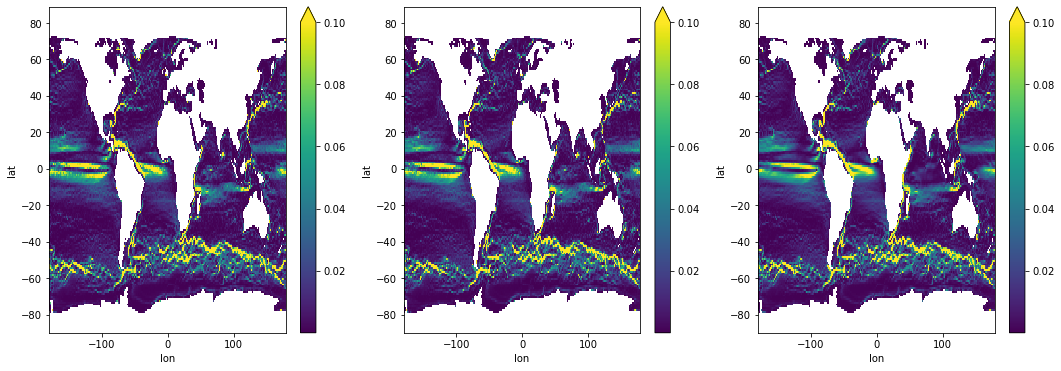

In [45]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
(ds_Lstats.zonal_velocity**2+ds_Lstats.meridional_velocity**2).plot(y='lat',vmax=0.1,ax=ax[0])
(ds_Lstats.bmean_zonal_velocity**2+ds_Lstats.bmean_meridional_velocity**2).plot(y='lat',vmax=0.1,ax=ax[1])

(ds_Lstats.mean_zonal_velocity**2+ds_Lstats.mean_meridional_velocity**2).plot(y='lat',vmax=0.1,ax=ax[2])

$<<u>>^2+<<v>>^2$

$<\bar u^2+\bar v^2>$

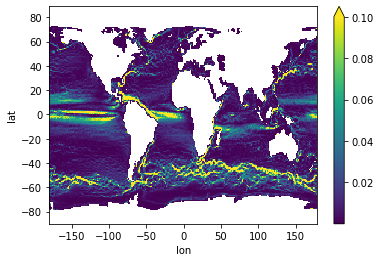

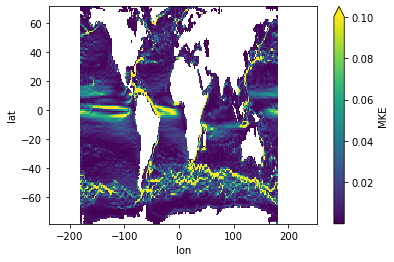

In [52]:
(ds_Lstats.bmean_zonal_velocity**2+ds_Lstats.bmean_meridional_velocity**2).plot(y='lat',vmax=0.1)
plt.figure()
(ds_mean.MKE).plot(y='lat',vmax=0.1)

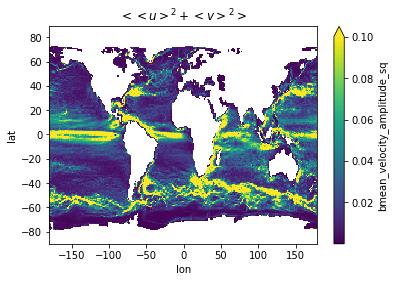

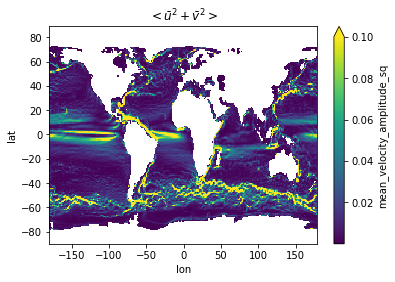

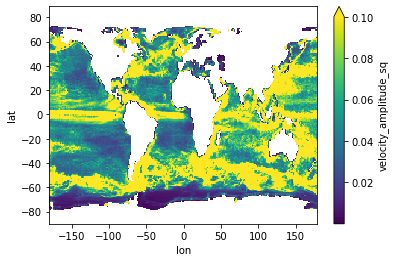

In [17]:
(ds_Lstats.bmean_velocity_amplitude_sq).plot(y='lat',vmax=0.1)
plt.title(r'$<<u>^2+<v>^2>$')
plt.figure()
(ds_Lstats.mean_velocity_amplitude_sq).plot(y='lat',vmax=0.1)
plt.title(r'$<\bar u^2+\bar v^2>$')
plt.figure()
(ds_Lstats.velocity_amplitude_sq).plot(y='lat',vmax=0.1)

Text(0.5, 1.0, '$<<\\bar u>^2+<\\bar v>^2>$')

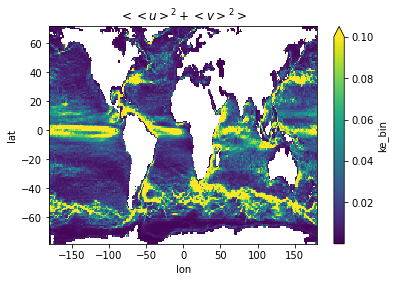

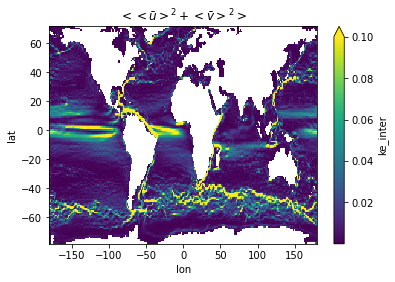

In [24]:
df_mean.ke_bin.plot(y='lat',vmax=0.1)
plt.xlim(-180,180)
plt.title(r'$<<u>^2+<v>^2>$')
plt.figure()
df_mean.ke_inter.plot(y='lat',vmax=0.1)
plt.xlim(-180,180)
plt.title(r'$<<\bar u>^2+<\bar v>^2>$')

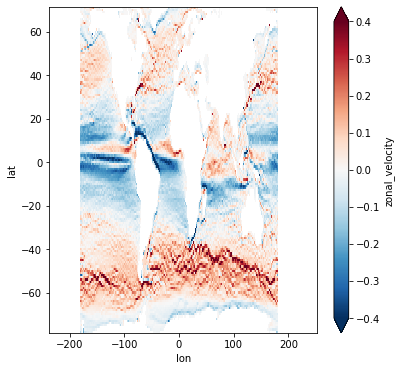

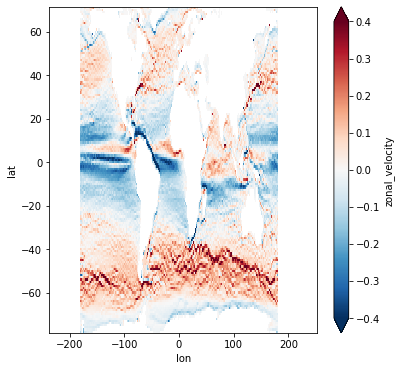

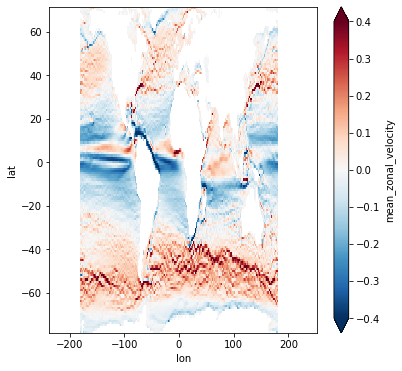

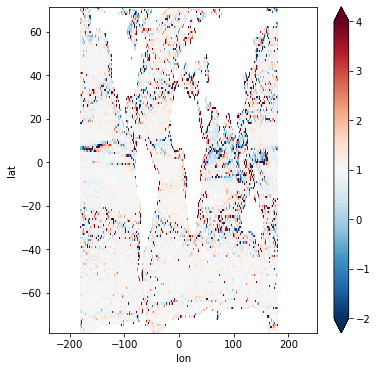

In [33]:
plt.figure(figsize=(6,6))
ds_mean.zonal_velocity.plot(y='lat',vmax=0.4)
plt.figure(figsize=(6,6))
df_mean.zonal_velocity.plot(y='lat',vmax=0.4)
plt.figure(figsize=(6,6))
ds_mean.mean_zonal_velocity.plot(y='lat',vmax=0.4)
plt.figure(figsize=(6,6))
(ds_mean.mean_zonal_velocity/ds_mean.zonal_velocity).plot(y='lat',vmax=4,vmin=-2,cmap='RdBu_r')

$<u>$, $<u^2>$, $<\bar u>$, $<\bar u^2>$ : 

$<u>\sim<\bar u>$

MKE : $<u>^2+<v>^2$, $<\bar u>^2+<\bar v>^2$

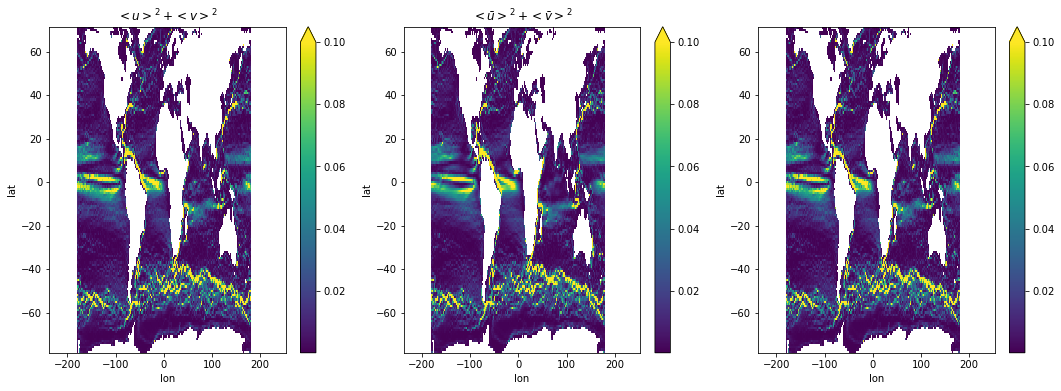

<Figure size 432x432 with 0 Axes>

In [48]:
vmax = 0.1
fig,ax = plt.subplots(1,3,figsize=(18,6))
(ds_mean.zonal_velocity**2+ds_mean.meridional_velocity**2).plot(y='lat',vmax=vmax,ax=ax[0])
ax[0].set_title(r'$<u>^2+<v>^2$')
plt.figure(figsize=(6,6))
(ds_mean.mean_zonal_velocity**2+ds_mean.mean_meridional_velocity**2).plot(y='lat',vmax=vmax,ax=ax[1])
ax[1].set_title(r'$<\bar u>^2+<\bar v>^2$')

(df_mean.zonal_velocity**2+df_mean.meridional_velocity**2).plot(y='lat',vmax=vmax,ax=ax[2])

Text(0.5, 1.0, '$<\\bar u^2>$')

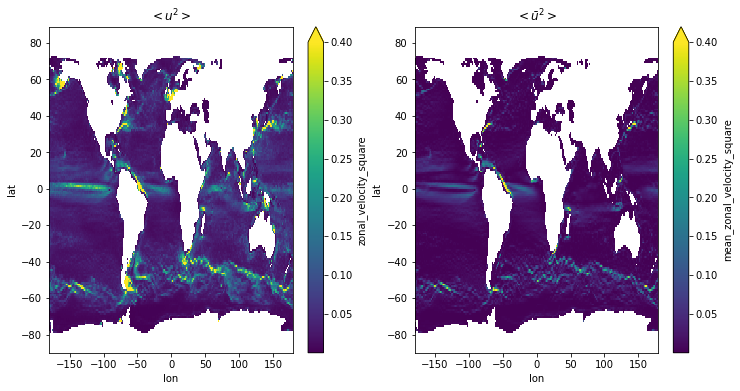

<Figure size 432x432 with 0 Axes>

In [36]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
(ds_mean.zonal_velocity_square).plot(y='lat',vmax=0.4,ax=ax[0])
ax[0].set_title(r'$<u^2>$')
plt.figure(figsize=(6,6))
(ds_mean.mean_zonal_velocity_square).plot(y='lat',vmax=0.4,ax=ax[1])
ax[1].set_title(r'$<\bar u^2>$')

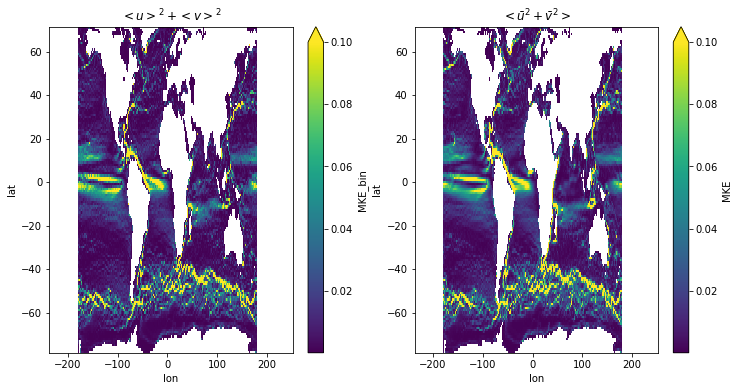

<Figure size 432x432 with 0 Axes>

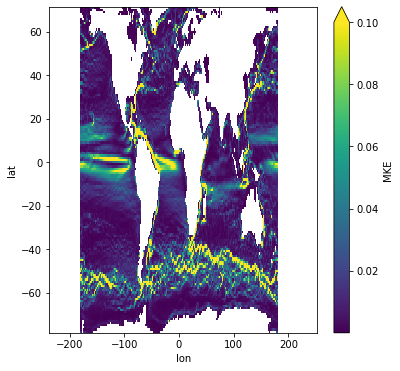

In [50]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
(ds_mean.MKE_bin).plot(y='lat',vmax=0.1,ax=ax[0])
ax[0].set_title(r'$<u>^2+<v>^2$')
plt.figure(figsize=(6,6))
(ds_mean.MKE).plot(y='lat',vmax=0.1,ax=ax[1])
ax[1].set_title(r'$<\bar u^2+\bar v^2>$')
plt.figure(figsize=(6,6))
(ds_mean.MKE).plot(y='lat',vmax=0.1)

Text(0.5, 1.0, '$<\\bar u^2+\\bar v^2>$')

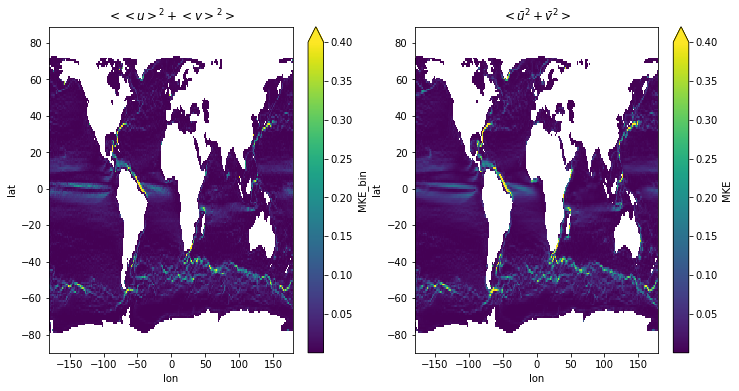

<Figure size 432x432 with 0 Axes>

In [41]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
(ds_mean_mean.MKE_bin).plot(y='lat',vmax=0.4,ax=ax[0])
ax[0].set_title(r'$<<u>^2+<v>^2>$')
plt.figure(figsize=(6,6))
(ds_mean.MKE).plot(y='lat',vmax=0.4,ax=ax[1])
ax[1].set_title(r'$<\bar u^2+\bar v^2>$')

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
(ds_mean_mean.MKE_bin).plot(y='lat',vmax=0.4,ax=ax[0])
ax[0].set_title(r'$<<u>^2+<v>^2>$')
plt.figure(figsize=(6,6))
(ds_mean_mean.MKE_interp).plot(y='lat',vmax=0.4,ax=ax[1])
ax[1].set_title(r'$<<\bar u>^2+\bar v^2>$')

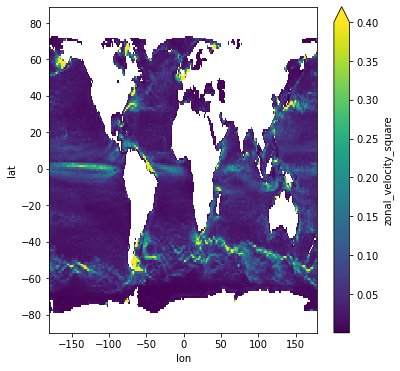

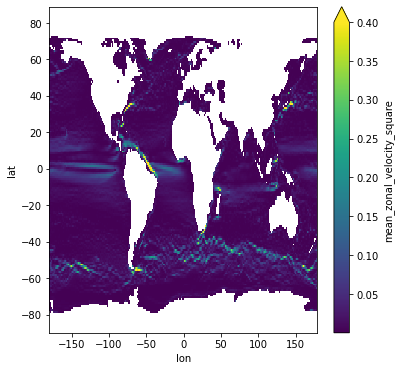

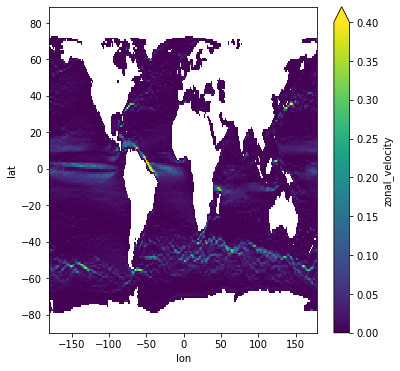

In [18]:
plt.figure(figsize=(6,6))
ds_mean.zonal_velocity_square.plot(y='lat',vmax=0.4)
plt.figure(figsize=(6,6))
ds_mean.mean_zonal_velocity_square.plot(y='lat',vmax=0.4)
plt.figure(figsize=(6,6))
(ds_mean.zonal_velocity**2).plot(y='lat',vmax=0.4)

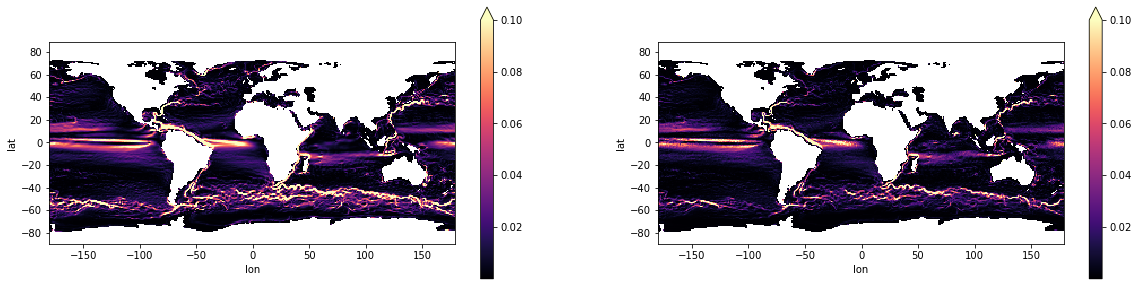

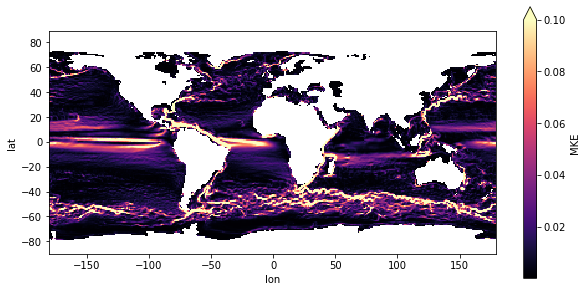

In [77]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
(ds_mean.mean_zonal_velocity**2+ds_mean.mean_meridional_velocity**2).plot(ax=ax[0],y='lat',cmap='magma',vmax=0.1)
ax[0].set_aspect('equal')
((ds_mean.zonal_velocity**2+ds_mean.meridional_velocity**2)/ds_mean.area).plot(ax=ax[1],y='lat',cmap='magma',vmax=0.1)
ax[1].set_aspect('equal')
fig,ax = plt.subplots(figsize=(10,5))
ds_mean.MKE.plot(ax=ax,y='lat',cmap='magma',vmax=0.1)
ax.set_aspect('equal')




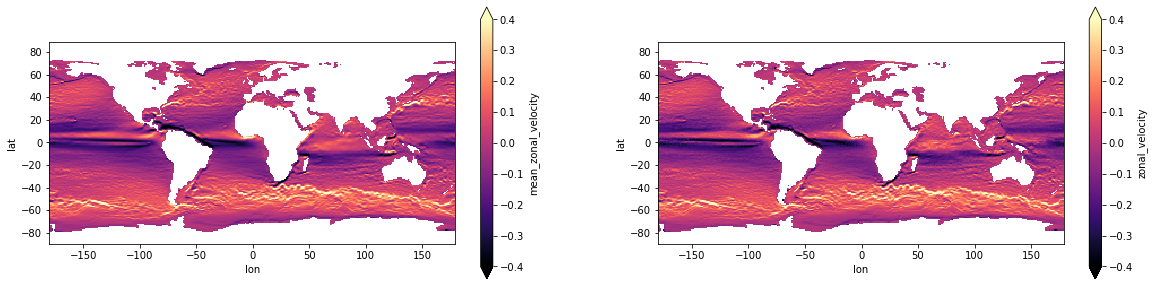

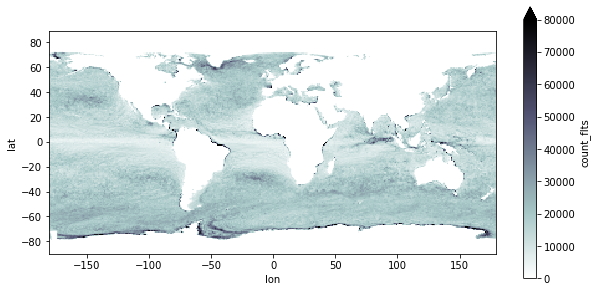

In [53]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
ds_mean.mean_zonal_velocity.plot(ax=ax[0],y='lat',cmap='magma',vmax=0.4)
ax[0].set_aspect('equal')
ds_mean.zonal_velocity.plot(ax=ax[1],y='lat',cmap='magma',vmax=0.4)
ax[1].set_aspect('equal')
fig,ax = plt.subplots(figsize=(10,5))
ds_mean.count_flts.plot(ax=ax,y='lat',cmap='bone_r',vmax=80000)
ax.set_aspect('equal')

In [78]:
mean_flts['MKE_bin'] = mean_flts.zonal_velocity**2+mean_flts.meridional_velocity**2
t_mean = mean_flts.groupby(mean_flts.index).mean()

In [79]:
t_mean = pa.add_geodata(t_mean)

In [80]:
ds_mean_mean = (t_mean
           .drop(columns=['Coordinates'])
           .set_index(['lon', 'lat'])
           .to_xarray()
           )

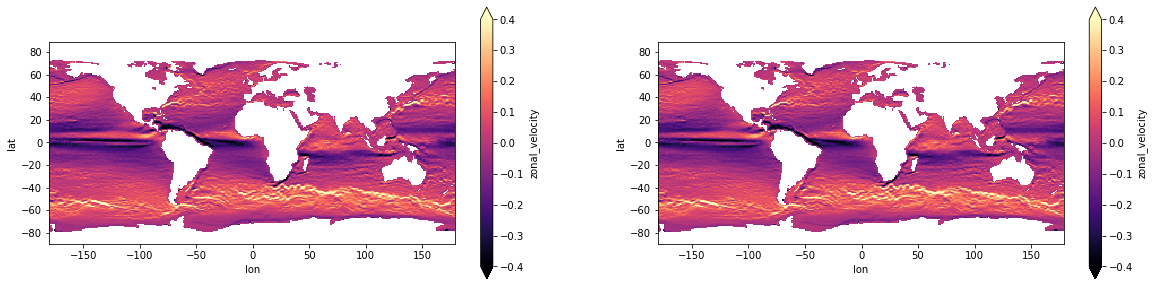

In [66]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
ds_mean.zonal_velocity.plot(ax=ax[0],y='lat',cmap='magma',vmax=0.4)
ax[0].set_aspect('equal')
ds_mean_mean.zonal_velocity.plot(ax=ax[1],y='lat',cmap='magma',vmax=0.4)
ax[1].set_aspect('equal')

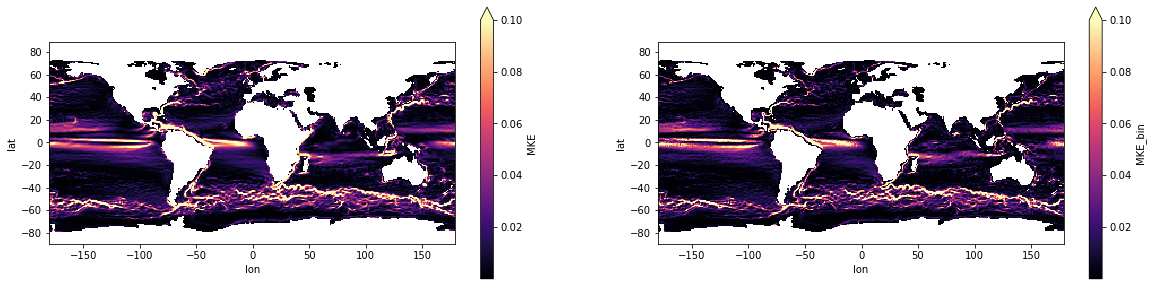

In [82]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
ds_mean.MKE.plot(ax=ax[0],y='lat',cmap='magma',vmax=0.1)
ax[0].set_aspect('equal')
ds_mean_mean.MKE_bin.plot(ax=ax[1],y='lat',cmap='magma',vmax=0.1)
ax[1].set_aspect('equal')

In [99]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
